**\underline{Final Project Submission}** 

Please fill out:
* **Student name:** Milad Shirani
* **Student pace:** self paced
* **Scheduled project review date/time:** Thursday, February, 24, 2020 at 14:00 Pacific Time.
* **Instructor name:** Claude Fried
* **Blog post URL:** https://medium.com/@milad_shirani/statistical-power-98c8f64f909d
* **Github:** use the [link](https://github.com/miladshiraniUCB/dsc-phase-2-project-v2-3.git) or copy-paste: 

```
https://github.com/miladshiraniUCB/dsc-phase-2-project-v2-3.git
```

# Introduction  (DONE)

**King County in Washington** State has decided to help newly married couples to find a property in this county and the county wants to find a way to estimate the value of a property and wants to know two ways that can help them to increase the value of a property. They asked a data scientist to find a model to predict the price of a property and two suggestions to increase the value of a property.

Therefore, in this note, we are trying to help homeowners to buy or sell homes by predicting the price of the property in King County, WA. We will give them some suggestions how they could increase the value of the property and what are the main features that have th highest influence on the price of the property. To answer their questions, we use some available data from the housing prices in this county to present a model to predict the price of a house. 

In order to do so, we use regression methods to find an appropriate model to fit housing price data so that we can predict the price of different houses with different features. 


This notebook is organized as follows:

**2. Importing data.** In this part we import the data and we will introduce which columns it contains. 


**3. Functions.** This section contains the functions we defined to perform special computations for us. These functions are:

        3.1 corr
        3.2 summary_of_results
        3.3 concatenate

**4. Some Insight Into Data.** In this section we are trying to identify the categorical and numerical features. By plotting some graphs, we will find the outliers and how to clean the data. This section has the following subsections:

        4.1 Scatter Plots for Categorical Features
        4.2 Scatter Plots for Numerical data
        4.3 Cleaning data
        

**5. Categorical.** In this section, we are converting the categorical data into numerical values to be able to use them in the model. This section contains the following subsections:

        5.1 Dealing with Null Values
        5.2 Converting multi categorical columns to numerical values
        
**6. Preprocessing.** In this section, we are going to see the effects of containing different categorical and numerical variables on `R2` score to see which features we need to keep. This section contains:

        6.1 First Model: Putting `grade`, `condition` and `zipcode` into the model.
        6.2 Second Model: Putting only `condition` into the model.
        6.3 Third Model: Putting `grade` and `condition`  into the model.
        6.5 Forth Model-Part 1: Considering only `grade`  into the modeling.
        6.5 Forth Model-Part 2: Considering only `grade`  into the modeling.
        
**7. Features Selection.** In this section, based on the dataframe that we found in the previous section, we will try to find the features that we have more information but low collinearity and high `R2` score. We use different approaches to decide which features we need to keep. These approaches are used in different subsections which are: 

        7.1 First Approach By using p-values, R2 scores and Condition number.
        
**8. Final Model.** In this section, we find the baseline model to compare the model we found in the previous section with. This section contains the following subsections:

        8.1 Baseline Model
        8.2 Final Model
        8.3 Interpretation of Coefficients


**9. Prediction.** We will use the model introduced in the section 9 to predict some data. 


**10. Assumption Checking.** In this section, we are going to check the regression model's assumptions to see if they are satisfied or not. This section contains the following subsections:

        11.1 Normality of Residuals
        11.2 Investigating Multicollinearity (Independence Assumption)
        11.3 Investigating Homoscedasticity
        11.4 Investigating Linearity
        


**11. Summary and Suggestions.** In this section we discuss the model and we will we will give some suggestions as an answer to our business question.


**12. Next Steps.** In this section we suggest how we may be able to improve the accuracy of our model.

# Importing Data  (DONE)

First we are going to import the data and save them into a dataframe called `data_initial`. After that we select some columns as the features of our model. The `dataframe` that we are using in the rest of the work contains the following type of variables:

1. Numerical Columns

    * `price`
    * `bedrooms`
    * `bathrooms`
    * `sqft_living`
    * `sqft_lot`
    * `floors`
    * `yr_built`
    * `lat`
    * `long`


2. Categorical Columns
    
    * `waterfront`
    * `condition`
    * `grade`
    * `zipcode`

However, we may not use all of these columns in our model and we need to choose among them as features of our final model.


In [153]:
import os
import numpy as np
from glob import glob
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

data_initial = pd.read_csv("./data/kc_house_data.csv")

to_drop_initial = ["date", "view", "sqft_above" ,"sqft_basement", "yr_renovated", 
           "sqft_living15", "sqft_lot15", "id"]

df = data_initial.drop(columns = to_drop_initial, axis = 1)

# Functions we use  (DONE)

In this section, the functions we used to get some information about data (`corr` function) or create a final dataframe to use (`concatenate` function) or will return the `R2`score and condition number (`summary_of_results` function). These functions are:

1. `corr`
2. `summary_of_results`
3. `concatenate`

Each of these functions is introduced below.

## `corr`

In order to get the correlation coefficients, we define a function that takes two inputs which are data and then the minimum value of the correlation. This minimum value will be used to find features with correlation more than or equal to this minimum value. 


In [154]:
def corr(data, value):
    corr_table = data.corr().abs().stack().reset_index().sort_values(0, 
                                                            ascending=False)
    
    corr_table["pairs"]=list(zip(corr_table["level_1"],corr_table["level_0"]))
    
    corr_table.drop(columns = ["level_1", "level_0"], inplace = True)
    corr_table.reset_index(inplace = True, drop = True)


    corr_1 = corr_table.iloc[0:len(data.columns)].index
    corr_table.drop(index = corr_1, inplace = True)
    corr_table.reset_index(inplace = True, drop = True)
    table1 = corr_table.iloc[range(0, len(corr_table), 2)]
    table = table1.loc[table1[0]>value]
    table.reset_index(inplace = True, drop = True)
    
    
    return table

## `summary_of_results`

In order to update the text automatically and get `R2` score and collinearity, we are going to convert `results_summary` obtained from `statsmodels` library into `Pandas DataFrame` to find `R2-scores`, `coefficients` and `P-values` for different models.

In [155]:
def summary_of_results(data, to_drop, pval):
    import statsmodels.api as sm
    
    features = df_final.drop(columns = to_drop, axis = 1)
    X = sm.add_constant(features)
    model = sm.OLS(df_final["price"], X)
    results = model.fit()
    results_summary = results.summary()
    
    ### Converting results_summary to pandas dataframe
    results_R2 = results_summary.tables[0].as_html()
    R2_df = pd.read_html(results_R2, header=0, index_col=0)[0]
    R2_df.reset_index(inplace = True)
    R2_df = R2_df.columns.to_frame().T.append(R2_df, ignore_index=True)
    R2_df.columns = range(len(R2_df.columns))
    
    

    results_coeff = results_summary.tables[1].as_html()
    coeff_df = pd.read_html(results_coeff, header=0, index_col=0)[0]
    coeff_df.reset_index(inplace = True)
    coeff_df = coeff_df.columns.to_frame().T.append(coeff_df, 
                                                    ignore_index=True)
    coeff_df.columns = range(len(coeff_df.columns))



    results_collin = results_summary.tables[2].as_html()
    collin_df = pd.read_html(results_collin, header=0, index_col=0)[0]
    collin_df.reset_index(inplace = True)
    collin_df = collin_df.columns.to_frame().T.append(collin_df, 
                                                      ignore_index=True)
    collin_df.columns = range(len(collin_df.columns))
    
    
    R2 = R2_df.iloc[0, 3]

    collinearity_num = collin_df.iloc[3, 3]

    coeff = coeff_df.iloc[1:,[0,4, 1]]
    
    coeff.columns = ["feature", "P-value", "coefficient"]
    
    coeff["coefficient_absolute_value"] = np.abs(coeff["coefficient"])
    coeff.sort_values(by = "coefficient_absolute_value", 
                            ascending = True, inplace = True)
    
    
    critical_pval = coeff.loc[coeff["P-value"]>= pval]

    
    return [R2, collinearity_num, critical_pval, coeff]

## `concatenate`

This functions will return the final dataframe that we use for our analysis.

In [156]:
def concatenate(  
               include_grade = False,     
               include_zipcode = False,
               include_condition = False
                ):
    
    data    = df_no_outliers 
    sub_df1 = grade_num_df
    sub_df2 = zipcode_num_df
    sub_df3 = condition_num_df
    
    include_sub_df1 = include_grade
    include_sub_df2 = include_zipcode
    include_sub_df3 = include_condition
    
    if (include_sub_df1 == True 
        and include_sub_df2 == False 
        and include_sub_df3 == False):
        
        df_final = pd.concat([data, sub_df1], axis = 1)
        
    elif (include_sub_df1 == False 
        and include_sub_df2 == True 
        and include_sub_df3 == False):
        
        df_final = pd.concat([data, sub_df2], axis = 1)
        
    elif (include_sub_df1 == False 
        and include_sub_df2 == False 
        and include_sub_df3 == True):
        
        df_final = pd.concat([data, sub_df3], axis = 1)    
        
    elif include_sub_df1 == True and include_sub_df2 == True:
        
        df_final = pd.concat([data, sub_df1, sub_df2], axis = 1)
        
    elif include_sub_df1 == True and include_sub_df3 == True: 
        
        df_final = pd.concat([data, sub_df1, sub_df3], axis = 1)
        
    elif include_sub_df2 == True and include_sub_df3 == True: 
        
        df_final = pd.concat([data, sub_df2, sub_df3], axis = 1)
        
    else:
        
        df_final = pd.concat([data, sub_df1, sub_df2, sub_df3], axis = 1)
        
    return df_final

# Some Insight Into Data  (DONE)

In order to find the outliers and how the data looks like, we will check the scatter plots of both categorical and numerical data as well as histogram for numerical data. In order to do so, first we need to find categorical and numerical data. To do this we use `select_dtypes` method as shown below:

In [157]:
y = df["price"]
numerical  = df.drop(columns = ["price", "zipcode"], axis = 1).select_dtypes(
    include=["float64", "int64"])
l = list(numerical.columns)
l.append("price")
categorical = df.drop(columns = l, axis = 1)

## Scatter Plots for Categorical Features

By studying the scatter plots of different categorical variable vs. price, we may find some points that can be considered not that much useful. For example, we see that we only have one data point for `3 Poor` in `grade` column, so we may drop this because we cannot use it. 

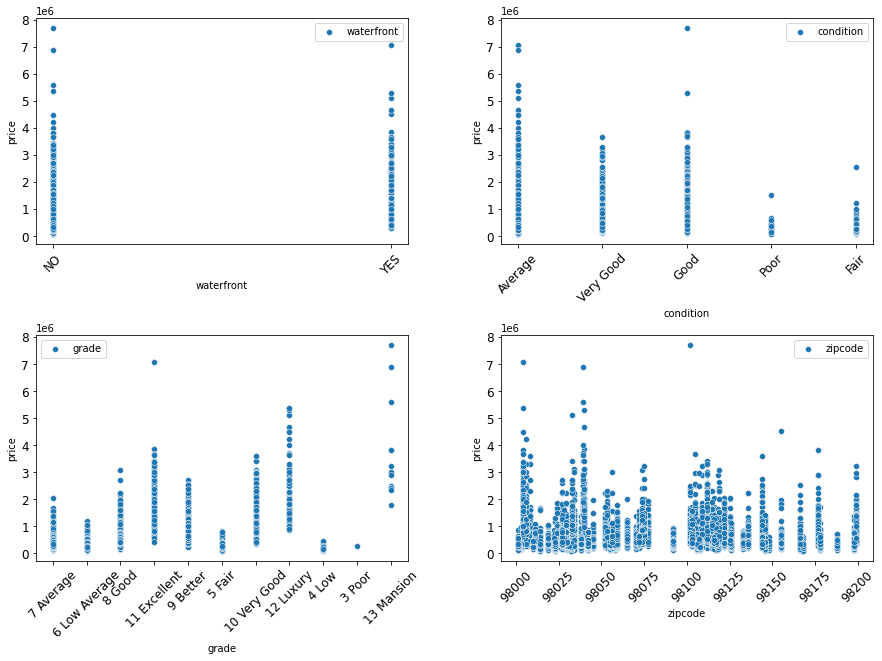

In [158]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))

fig.subplots_adjust(hspace=0.4, wspace=0.25)

to_pick = list(categorical.columns)

for i,col in enumerate(to_pick):
    ax = axes[i//2][i%2]
    sns.scatterplot(x = df[col], y = df["price"], ax = ax, label = col)
    ax.tick_params(axis='x', labelrotation = 45, labelsize = 12)
    ax.tick_params(axis='y', labelrotation = 0, labelsize = 12)
    

In [159]:
len(df.loc[df["grade"] == "3 Poor"])

1

## Scatter Plots for Numerical data

In this section, by checking the scatter plot of numerical data vs. price, we may be able to find some outliers. For example we see that there is a point with more than 30 rooms. Also, we see that there are houses with less than a bathroom. So, checking these scatter plots will help us with finding some outliers and not that useful data points.

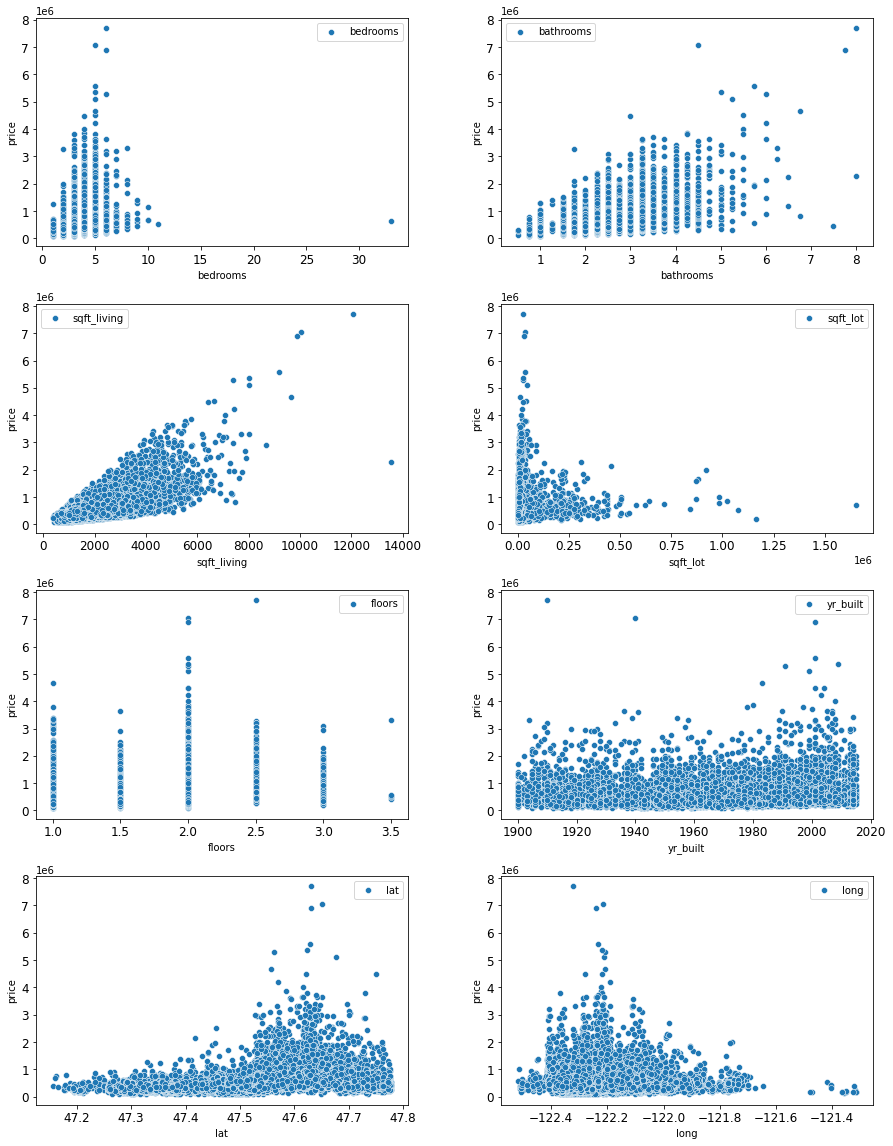

In [160]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (15,20))
fig.subplots_adjust(hspace=0.25, wspace=0.25)

to_pick = list(numerical.columns)

for i,col in enumerate(to_pick):
    ax = axes[i//2][i%2]
    sns.scatterplot(x = df[col], y = df["price"], ax = ax, label = col)
    ax.tick_params(axis='x', labelrotation = 0, labelsize = 12)
    ax.tick_params(axis='y', labelrotation = 0, labelsize = 12)
    

In [161]:
len(df.loc[df["floors"] == 3.5])

7

## Cleaning data

First we are going to drop the outliers for highest and lowest prices. In order to do so, we are going to drop the row in `price` column that are more/less than 3 standard deviations from average price. In order to do that, we are going to use the function `stats.zscore` from `scipy.stats` library.

In [162]:
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

z = stats.zscore(df["price"], ddof=0)
df["z_score"] = stats.zscore(df["price"], ddof=0)
df_no_outliers = df.loc[(df["z_score"] < 3) & (df["z_score"] > -3)]
df_no_outliers.drop(columns = "z_score", axis = 1, inplace = True)

As we can see there are some outliers in the `bedrooms`, `sqft_lot` and `sqft_living`. So, we are going to drop houses with more than `{{max_b}}` bedrooms, `{{max_bath}}` bathrooms, and `{{max_floors}}` floors as well as houses with less than `{{min_bath}}` bathrooms. Moreover, we are going to drop the houses with the highest values of `sqft_lot` and `sqft_living` and the only data whose grade is `3 Poor`.

In [163]:
max_b = 8 
max_bath = 7
min_bath = 1
max_floors = 3.5
max_lot = max(df_no_outliers["sqft_lot"])
max_liv = max(df_no_outliers["sqft_living"])

condition = ((df_no_outliers["bedrooms"] == max_b)
             | (df_no_outliers["bathrooms"] == max_bath) 
             | (df_no_outliers["bathrooms"] < min_bath) 
             | (df_no_outliers["sqft_lot"] == max_lot)
             | (df_no_outliers["sqft_living"] == max_liv)
             | (df_no_outliers["grade"] == "3 Poor")
             | (df_no_outliers["floors"] == max_floors))

ind = df_no_outliers.loc[condition].index
df_no_outliers.drop(index = ind, inplace = True)


In [164]:
y = df_no_outliers["price"]
numerical  = df_no_outliers.drop(columns = ["price", "zipcode"]
                    , axis = 1).select_dtypes(include=["float64", "int64"])
l = list(numerical.columns)
l.append("price")
categorical = df_no_outliers.drop(columns = l, axis = 1)

Now we are going to convert (scaling and normalizing) the data in the columns `price`, `lat`, `long`, `yr_built`, `sqft_living` and `sqft_lot` to make the data more normal. However, if we check we realize that the values of the column `long` are all negative and we need to first multiply them with a minus sign to be able to convert them by a logarithmic function. 

In [165]:
sum(df_no_outliers["long"] > 0)
df_no_outliers["long"] = -1 * df_no_outliers["long"]
to_convert = ["price", "long", "lat", 'sqft_living', 'sqft_lot', "yr_built" ] 
for item in to_convert:
    if item == "price":
        df_no_outliers[item] = np.log(df_no_outliers[item])
    else:
        df_no_outliers[item] = np.log(df_no_outliers[item])
        numerical[item] = np.log(numerical[item])
        
        

After cleaning, we are going to check the histogram and scatter plots of the data that are recently converted.

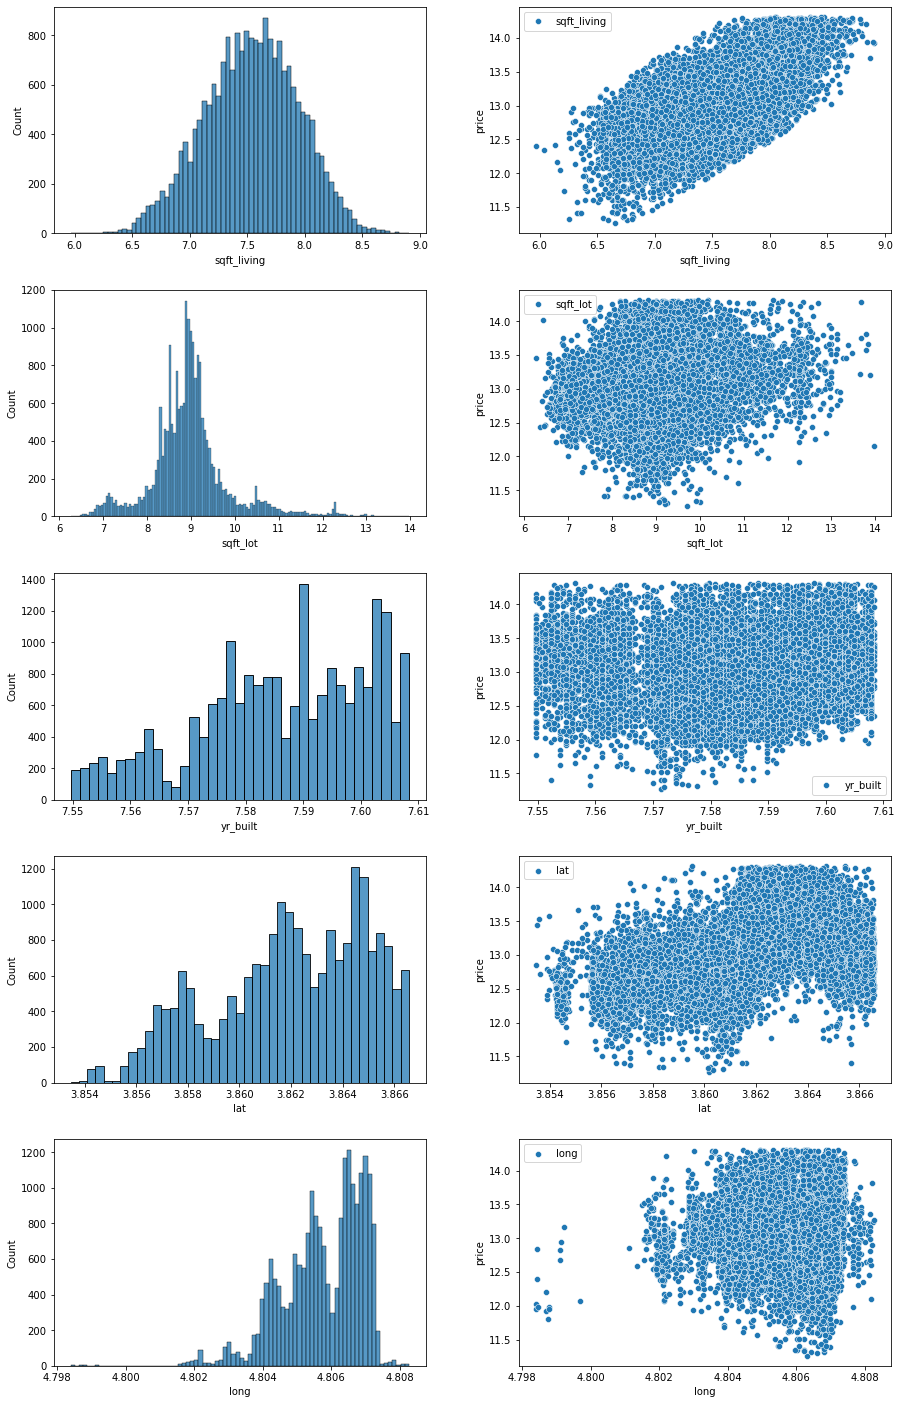

In [166]:
to_pick = list(numerical.columns)

to_pick.remove("bedrooms")
to_pick.remove("bathrooms")
to_pick.remove("floors")


r = len(to_pick)
c = 2
fig, axes = plt.subplots(nrows = r, ncols = c, figsize = (15,25))
fig.subplots_adjust(hspace=0.25, wspace=0.25)



for i,col in enumerate(to_pick):
    axh = axes[i%r][0]
    axs = axes[i%r][1]
    sns.histplot(x = df_no_outliers[col],ax = axh, label = col)
    sns.scatterplot(x = df_no_outliers[col],y = df_no_outliers["price"]
                    , ax = axs, label = col)
    ax.tick_params(axis='x', labelrotation = 0, labelsize = 12)
    ax.tick_params(axis='y', labelrotation = 0, labelsize = 12)

Let's also check the histogram and Q-Q plot of `price` to see if `price` is normal or not.

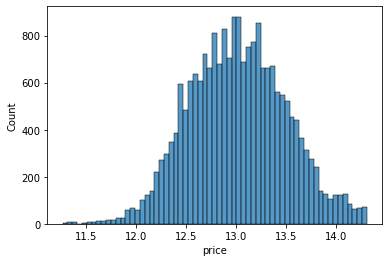

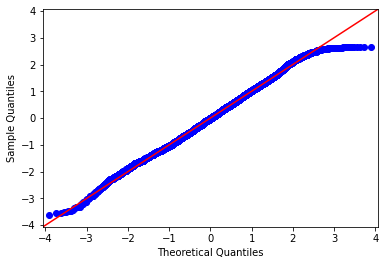

In [167]:
import scipy.stats as stats
import statsmodels.api as sm


sns.histplot(x = df_no_outliers["price"], label = "price");
sm.graphics.qqplot(df_no_outliers["price"], 
                   dist=stats.norm, line='45', fit=True);

# Categorical  (DONE)

We need to convert the categorical data to numerical values so that we can use them in our model. First we are going to find the columns that have missing data. 

In [168]:
a = categorical.isna().sum().to_frame().reset_index()

We can see that only `{{a.iloc[0,0]}}` has missing values and the the total number of values that are missed is `{{a.iloc[0,1]}}`.


## Dealing with Null Values

First we are going to create a new column for missing values. We know that the column `{{a.iloc[0,0]}}` has `{{a.iloc[0,1]}}` missing values. Therefore, we are going to create a column called `{{a.iloc[0,0]}}_null` to indicate where data is missing. In order to do so, we take the following steps.

First we use `MissingIndicator` from `sklearn.impute` to create a column in `df` called `{{a.iloc[0,0]}}_null` as shown below:


In [169]:
### Missing Indicator for waterfront
import warnings 
from sklearn.impute import MissingIndicator
warnings.filterwarnings("ignore")
missing_indicator = MissingIndicator()

null_val = df_no_outliers[["waterfront"]]
missing_indicator.fit(null_val)

df_no_outliers["waterfront_null"] = missing_indicator.transform(null_val)


After creating a new column for the missing values, we are going to to impute the missing values in the column `{{a.iloc[0,0]}}` by using `SimpleImputer` from `sklearn.impute` as done below

In [170]:
### Imputing Missing Values for waterfront

import warnings
warnings.filterwarnings("ignore")


from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(df_no_outliers[["waterfront"]])
df_no_outliers["waterfront_impute"] = imputer.transform(
    df_no_outliers[["waterfront"]])

At the end, we will use `OrdinalEncoder` from `from sklearn.preprocessing` to convert the binary values into numerical values. To do so, first we need to convert the Column `waterfront_impute` to numerical value as:

In [171]:
### Converting the Column waterfront_impute to numerical value
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OrdinalEncoder

encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(df_no_outliers[["waterfront_impute"]])


encoder_waterfront_transform = encoder_waterfront.transform(
    df_no_outliers[["waterfront_impute"]]).flatten()


df_no_outliers["waterfront_impute"] = encoder_waterfront_transform

df_no_outliers.drop(columns = ['waterfront'], inplace = True, axis = 1)



Now we are going to convert the column `waterfront_null` to Numerical value.

In [172]:
### Converting the Column waterfront_null to Numerical value

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OrdinalEncoder

encoder_waterfront_null = OrdinalEncoder()
encoder_waterfront_null.fit(df_no_outliers[["waterfront_null"]])



encoder_waterfront_null_transform = encoder_waterfront_null.transform(
    df_no_outliers[["waterfront_null"]]).flatten()

df_no_outliers["waterfront_null"] = encoder_waterfront_null_transform


## Converting multi categorical columns to numerical values

The categorical multiple values are stored in columns `condition`, `grade` and `zipcode`. In order to convert them to numerical values we should use `OneHotEncoder` from `sklearn.preprocessing`. 

First we are going to convert the categorical variable `condition` to numerical values in the following cell.

In [173]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder

condition_cat = df_no_outliers[["condition"]]

ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
ohe.fit(condition_cat)

condition_num = ohe.transform(condition_cat)
condition_num_df = pd.DataFrame(condition_num, 
                               columns = ohe.categories_[0],
                               index = df_no_outliers.index)
df_no_outliers.drop(columns = ["condition"], inplace = True, axis = 1)

In the following cell, we are going to do the same thing to convert `grade` to numerical values

In [174]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder

grade_cat = df_no_outliers[["grade"]]

ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
ohe.fit(grade_cat)


grade_num = ohe.transform(grade_cat)
grade_num_df = pd.DataFrame(grade_num, 
                           columns = ohe.categories_[0],
                           index = df_no_outliers.index)
df_no_outliers.drop(columns = ["grade"], inplace = True, axis = 1)

And finally, we are going to converting `zipcode` to numerical values in the following cell

In [175]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder

zipcode_cat = df_no_outliers[["zipcode"]]

ohe = OneHotEncoder(categories='auto', sparse=False, drop= "first")
ohe.fit(zipcode_cat)
zipcode_num = ohe.transform(zipcode_cat)

zipcode_num_df = pd.DataFrame(zipcode_num, 
                           columns = ohe.categories_[0][1:],
                           index = df_no_outliers.index)
df_no_outliers.drop(columns = ["zipcode"], inplace = True, axis = 1)

# Preprocessing  (DONE)

In order to create a model, first we need to decide what features we want to consider in our model. Initially, we will try to calculate `R2` score and `Cond. No.` for different combinations of categorical features to decide which combination we want to choose.

## First Model: Putting `grade`, `condition` and `zipcode` into the model.

First we want to see how different features affect the data. If we include `grade_num_df`, `zipcode_num_df` and `condition_num_df`, we get `R2-score` and collinearity as:

In [213]:
df_final = concatenate(include_grade = True, include_zipcode = True,
                       include_condition = True)
to_drop = ["price"]

l = summary_of_results(data = df_final, to_drop = to_drop, pval = 0.05)
print("R2        : ", l[0])
print("Cond. No. : ", l[1])


R2        :  0.854
Cond. No. :  2380000000000000.0


the `R2` score which is `{{l[0]}}` is really good but `Cond. No.` which is `{{l[1]}}`. The value of `R2` score is really good, so we may consider it as a strong candidate for our model. In the next part we compare it with the baseline model.

### Comparison with the Baseline Model

We will create a baseline model with which we can compare the results of the first model. We consider the baseline model as the linear regression model between `price` and the variable that has the highest correlation with `price`. The following code, gives us the name of the variable that has the highest correlation with `price`

In [214]:
numerical_II = df_no_outliers.drop(columns = "price", axis = 1).select_dtypes(
    include=["float64", "int64"])
corr_column = list(numerical_II.columns)
corr_dict = {}
for item in corr_column:
    corr_dict[df_no_outliers["price"].corr(df_no_outliers[item])] = item
high_corr = corr_dict[max(corr_dict)]
high_corr


'sqft_living'

Now, we are going to find the `R2` of the base line model for different test train sets

In [215]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit


df_final
X = df_final[[high_corr]]
y = df_final["price"]
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y, random_state=42)



baseline_model = LinearRegression()
splitter = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train_b[[high_corr]],
    y=y_train_b,
    return_train_score=True,
    cv=splitter
)

Now we will make our model and will compare the result of the model with the baseline model

In [216]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit



X = df_final.drop(columns = to_drop, axis = 1)
y = df_final["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

second_model = LinearRegression()
splitter = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

secondmodel_scores = cross_validate(
    estimator=second_model,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score(mean):      ", secondmodel_scores["train_score"].mean())
print("Validation score(mean): ", secondmodel_scores["test_score"].mean())

print()

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score(mean):       0.8551291192177555
Validation score(mean):  0.8538385655400402

Train score:      0.4080095230264854
Validation score: 0.4147140046119352


The `R2` for the train set and cross validation set is really good so now we need to check the collinearity condition as done in the next part.

### Final Decision

In order for us to consider the model, we need to check the collinearity condition. If we calculate the `variance-inflation factors` we will notice that including `zipcode_num_df` into the final dataframe will cause a lot of collinearities as shown below

In [217]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


df_final = concatenate(include_grade = True, include_zipcode = True,
                       include_condition = True)


XX = df_final.drop(columns = to_drop, axis = 1)

XX_constant_added = sm.add_constant(XX)


vif = [
    variance_inflation_factor(XX_constant_added.values, i) 
    for i in 
       range(XX_constant_added.shape[1])
      ]
variance_inf_fact = pd.Series(vif, index=XX_constant_added.columns,
                              name="Variance Inflation Factor")

We can see that the number of coefficients with Variance Inflation Factor more than 5 is around

In [218]:
print(sum(variance_inf_fact>5))

49


Therefore, we just exclude `zipcode` from rest of the work and we can use `lat` and `long` as a method to check the location of different houses.

## Second Model: Putting only `condition` into the model.

If we only consider `condition` in the model, we find `R2` and `Cond. No.` as

In [219]:
df_final = concatenate(include_grade = False, include_zipcode = False,
                       include_condition = True)
to_drop = ["price"]
c = summary_of_results(data = df_final, to_drop = to_drop, pval = 0.05)
print("R2        : ", c[0])
print("Cond. No. : ", c[1])

R2        :  0.659
Cond. No. :  1.44e+16


Therefore, considering only `condition` in the model will result in `R2` score equals to `{{c[0]}}` and `Cond. No.` equals `{{c[1]}}` which are ,respectively, lower and higher than previous cases. Therefore, we should ignore this model. However, in the next part, we compare it with the baseline model and we will check the collinearity by using Variance Inflation Factor as:



### Creating Baseline Model and Checking this Model

We will create a baseline model with which we can compare the results of the first model. We consider the baseline model as the linear regression model between `price` and the variable that has the highest correlation with `price`. The following code, gives us the name of the variable that has the highest correlation with `price`

In [220]:
numerical_II = df_no_outliers.drop(columns = "price", axis = 1).select_dtypes(
    include=["float64", "int64"])
corr_column = list(numerical_II.columns)
corr_dict = {}
for item in corr_column:
    corr_dict[df_no_outliers["price"].corr(df_no_outliers[item])] = item
high_corr = corr_dict[max(corr_dict)]
high_corr


'sqft_living'

Now, we are going to find the `R2` of the base line model for different test train sets

In [221]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit


df_final
X = df_final[[high_corr]]
y = df_final["price"]
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y, 
                                                            random_state=42)

baseline_model = LinearRegression()
splitter = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train_b[[high_corr]],
    y=y_train_b,
    return_train_score=True,
    cv=splitter
)

Now we will make our model and will compare the result of the model with the baseline model

In [222]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit


X = df_final.drop(columns = to_drop, axis = 1)
y = df_final["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



second_model = LinearRegression()

splitter = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

secondmodel_scores = cross_validate(
    estimator=second_model,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score(mean):      ", secondmodel_scores["train_score"].mean())
print("Validation score(mean): ", secondmodel_scores["test_score"].mean())

print()

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score(mean):       0.6580499399681821
Validation score(mean):  0.6581866624906911

Train score:      0.4080095230264854
Validation score: 0.4147140046119352


### Final Decision

Even though, the `R2` score is very low, we will check the collinearity condition as shown below:

In [223]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


df_final = concatenate(include_grade = False, include_zipcode = False,
                       include_condition = True)
to_drop = ["price"]

XX = df_final.drop(columns = to_drop, axis = 1)

XX_constant_added = sm.add_constant(XX)


vif = [
    variance_inflation_factor(XX_constant_added.values, i) 
    for i in 
       range(XX_constant_added.shape[1])
      ]
variance_inf_fact = pd.Series(vif, index=XX_constant_added.columns,
                              name="Variance Inflation Factor")


In [224]:
variance_inf_fact

const                0.000000
bedrooms             1.669104
bathrooms            3.036816
sqft_living          3.257208
sqft_lot             1.642007
floors               1.757113
yr_built             2.065253
lat                  1.092286
long                 1.476550
waterfront_null      1.000601
waterfront_impute    1.016638
Average                   inf
Fair                      inf
Good                      inf
Poor                      inf
Very Good                 inf
Name: Variance Inflation Factor, dtype: float64

From this we realize that there are some collinearities in the model, also `R2` score is not good so we will ignore this model.

## Third Model: Putting `grade` and `condition`  into the model.

Now let's check how `grade_num_df` and `condition_num_df` affect the modeling. Therefore, we only consider these two features and we will get `R2-score` and collinearity as:

In [225]:
df_final = concatenate(include_grade = True, include_zipcode = False,
                       include_condition = True)
to_drop = ["price"]
gc = summary_of_results(data = df_final, to_drop = to_drop, pval = 0.05)
print("R2        : ", gc[0])
print("Cond. No. : ", gc[1])

R2        :  0.729
Cond. No. :  1.19e+17


Again, we see that the the `R2` score which is `{{gc[0]}}` is good but `Cond. No.` which is `{{gc[1]}}` is really high. However, both condition and grade might be responsible for the quality of the house and we can just exclude one of them and use the other one. Before deciding which one to drop, let's check the coefficients with `p-values` greater than 0.05. 

In [226]:
gc[2]

,feature,P-value,coefficient,coefficient_absolute_value
10,waterfront_null,0.445,-0.0042,0.0042


We can see that `{{list(gc[2]["feature"])[0]}}` has p-values more than the critical value of `0.05`. Therefore, we are going to drop this columns. On the other hand, if a house has a view to a water fall, they would not miss the data and they will state that the property has that view. So, `waterfall_null` might be just those houses that they do not have the view which they are already in the model. Therefore, we are going to include these categorical variables in the model and we will try to find the best features which will reduce the collinearity of the model's features. 

In [227]:
df_final.drop(columns = ["waterfront_null", "long"], axis = 1, inplace = True)

First we are going to drop `waterfront_null` and `long` from the dataframe and will check the `R2` and `Cond. No.`. At the same time we are going to calculate the correlation table to find the highly correlated features as

In [228]:
df_final = concatenate(include_grade = True, include_zipcode = False,
                       include_condition = True)
to_drop = ["price", "waterfront_null", "long"]
gc = summary_of_results(data = df_final, to_drop = to_drop, pval = 0.05)
print("R2        : ", gc[0])
print("Cond. No. : ", gc[1])

R2        :  0.729
Cond. No. :  1.13e+17


Also we may check the correlation coefficients as:

In [229]:
print(corr(df_final, value = 0.8))

          0            pairs
0  0.814728  (Good, Average)


As we can see, `Average` and `Good` are highly correlated so we are going to drop `Average` and will keep only `Good`.

In [230]:
df_final.drop(columns = ["Average"], axis = 1, inplace = True)

By checking the coefficients, we notice that there are several groups of features that almost have similar coefficients which can we group them to reduce the number of features. In order to do so, we define new columns that contains linear combination of these features. These columns are:

1. `df_final["MLE"] = df_final["13 Mansion"] + df_final["12 Luxury"] + df_final["11 Excellent"]`


2. `df_final["BV"] = df_final["10 Very Good"] + df_final["9 Better"]`


3. `df_final["LF"] = df_final["4 Low"] + df_final["5 Fair"]`


4. `df_final["LA"] = df_final["7 Average"] + df_final["6 Low Average"]`


Moreover, we notice that by ignoring the following features, we can significantly reduce the collinearity from `{{gc[1]}}` to `{{gc_new[1]}}`

 `3 Poor`, `8 Good` , `floors`, `bedrooms`, `Good`, `Very Good`, `floors`, `bedrooms`, `bathrooms`.

In [231]:
df_final = concatenate(include_grade = True, include_zipcode = False,
                       include_condition = True)
to_drop = ["price", "waterfront_null", "long"
          , "12 Luxury"
          , "11 Excellent", "10 Very Good", "9 Better"
          , "4 Low", "5 Fair", "7 Average", "6 Low Average"
          , "8 Good", "Average", "Good", "Very Good"
          , "floors", "bedrooms", "bathrooms"]


df_final["MLE"] = (df_final["11 Excellent"] + df_final["12 Luxury"])


df_final["BV"] = df_final["10 Very Good"] + df_final["9 Better"]
df_final["LF"] = df_final["4 Low"] + df_final["5 Fair"]
df_final["LA"] = df_final["7 Average"] + df_final["6 Low Average"]



gc_new = summary_of_results(data = df_final, to_drop = to_drop, pval = 0.05)
print("R2        : ", gc_new[0])
print("Cond. No. : ", gc_new[1])
print()

# gc_new[3]

R2        :  0.708
Cond. No. :  24200.0



However, we could not reduce the collinearity more than what we obtained. The reason might be because of including both categorical variables `condition` and `grade`. Therefore, we are jut going to pick one of them and we will drop the other one. 

In [232]:
df_final = concatenate(include_grade = True, include_zipcode = False,
                       include_condition = True)
to_drop = ["price", "waterfront_null", "long"
          , "12 Luxury", "11 Excellent"
          , "10 Very Good", "9 Better"
          , "4 Low", "5 Fair"
          , "7 Average", "6 Low Average"
          , "8 Good"
          , "Average", "Good", "Very Good"
          , "floors", "bedrooms", "bathrooms"]


df_final["EL"] = df_final["11 Excellent"]  +  df_final["12 Luxury"]
df_final["BV"] = df_final["9 Better"]      +  df_final["10 Very Good"] 
df_final["LF"] = df_final["4 Low"]         +  df_final["5 Fair"]
df_final["LA"] = df_final["6 Low Average"] + df_final["7 Average"]  




gc = summary_of_results(data = df_final, to_drop = to_drop, pval = 0.05)
print("R2        : ", gc[0])
print("Cond. No. : ", gc[1])
# gc[3]

R2        :  0.708
Cond. No. :  24200.0


### Creating Baseline Model and Checking this Model

We will create a baseline model with which we can compare the results of the first model. We consider the baseline model as the linear regression model between `price` and the variable that has the highest correlation with `price`. The following code, gives us the name of the variable that has the highest correlation with `price`

In [233]:
numerical_II = df_no_outliers.drop(columns = "price", axis = 1).select_dtypes(
    include=["float64", "int64"])
corr_column = list(numerical_II.columns)
corr_dict = {}
for item in corr_column:
    corr_dict[df_no_outliers["price"].corr(df_no_outliers[item])] = item
high_corr = corr_dict[max(corr_dict)]
high_corr


'sqft_living'

Now, we are going to find the `R2` of the base line model for different test train sets

In [234]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit

df_final
X = df_final[[high_corr]]
y = df_final["price"]
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y, random_state=42)


baseline_model = LinearRegression()
splitter = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train_b[[high_corr]],
    y=y_train_b,
    return_train_score=True,
    cv=splitter
)

Now we will make our model and will compare the result of the model with the baseline model

In [235]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit


X = df_final.drop(columns = to_drop, axis = 1)
y = df_final["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

second_model = LinearRegression()
splitter = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

secondmodel_scores = cross_validate(
    estimator=second_model,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score(mean):      ", secondmodel_scores["train_score"].mean())
print("Validation score(mean): ", secondmodel_scores["test_score"].mean())

print()

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score(mean):       0.7084364627537479
Validation score(mean):  0.7078056485082383

Train score:      0.4080095230264854
Validation score: 0.4147140046119352


### Final Decision

Now to check the collinearity we will use variance inflation factor to see which coefficient has a value more than 5.

In [236]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm



to_drop = to_drop

XX = df_final.drop(columns = to_drop, axis = 1)

XX_constant_added = sm.add_constant(XX)


vif = [
    variance_inflation_factor(XX_constant_added.values, i) 
    for i in 
       range(XX_constant_added.shape[1])
      ]
variance_inf_fact = pd.Series(vif, index=XX_constant_added.columns,
                              name="Variance Inflation Factor")


In [237]:
variance_inf_fact

const                2.658851e+06
sqft_living          2.053800e+00
sqft_lot             1.213567e+00
yr_built             1.361740e+00
lat                  1.103982e+00
waterfront_impute    1.006970e+00
Fair                 1.014862e+00
Poor                 1.013944e+00
EL                   1.124267e+00
BV                   1.518348e+00
LF                   1.169037e+00
LA                   1.815533e+00
Name: Variance Inflation Factor, dtype: float64

We can see that all of the coefficients are under 5 which is a good sign because it shows that the collinearity is minimized in this model. However, the issue is that the coefficients of the features `EL`, `BV`, `LF`, and `LA` are not clear and it is hard to interpret them. Therefore, we may ignore this model and move forward to find another model. 

## Forth Model-Part 1: Putting only `grade` into the model.

Now, if we only consider `grade` as the only categorical variable in the model, we find

In [238]:
df_final = concatenate(include_grade = True, include_zipcode = False,
                       include_condition = False)
to_drop = ["price"]
g = summary_of_results(data = df_final, to_drop = to_drop, pval = 0.05)
print("R2        : ", g[0])
print("Cond. No. : ", g[1])

R2        :  0.724
Cond. No. :  3.08e+16


Relative to the case where we only considered `condition`, we see that `R2` score has increased from `{{c[0]}}` to `{{g[0]}}` while `Cond. No.` has changed from `{{c[1]}}` to `{{g[1]}}`. So, we may consider it as a the proposed model. We will check it with the baseline model and we will check the collinearity of features in the next part.

### Creating Baseline Model and Checking this Model

We will create a baseline model with which we can compare the results of the first model. We consider the baseline model as the linear regression model between `price` and the variable that has the highest correlation with `price`. The following code, gives us the name of the variable that has the highest correlation with `price`

In [239]:
numerical_II = df_no_outliers.drop(columns = "price", axis = 1).select_dtypes(
    include=["float64", "int64"])
corr_column = list(numerical_II.columns)
corr_dict = {}
for item in corr_column:
    corr_dict[df_no_outliers["price"].corr(df_no_outliers[item])] = item
high_corr = corr_dict[max(corr_dict)]
high_corr


'sqft_living'

Now, we are going to find the `R2` of the base line model for different test train sets

In [240]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit


df_final
X = df_final[[high_corr]]
y = df_final["price"]
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y, 
                                                            random_state=42)

baseline_model = LinearRegression()
splitter = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train_b[[high_corr]],
    y=y_train_b,
    return_train_score=True,
    cv=splitter
)

Now we will make our model and will compare the result of the model with the baseline model

In [241]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit


X = df_final.drop(columns = to_drop, axis = 1)
y = df_final["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



second_model = LinearRegression()

splitter = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

secondmodel_scores = cross_validate(
    estimator=second_model,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score(mean):      ", secondmodel_scores["train_score"].mean())
print("Validation score(mean): ", secondmodel_scores["test_score"].mean())

print()

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score(mean):       0.7246336153907829
Validation score(mean):  0.7230445135776824

Train score:      0.4080095230264854
Validation score: 0.4147140046119352


### Final Decision

We need to check the collinearity condition  by calculating the `variance-inflation factors` as shown below:

In [242]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


df_final = concatenate(include_grade = True, include_zipcode = False,
                       include_condition = False)


XX = df_final.drop(columns = to_drop, axis = 1)

XX_constant_added = sm.add_constant(XX)


vif = [
    variance_inflation_factor(XX_constant_added.values, i) 
    for i in 
       range(XX_constant_added.shape[1])
      ]
variance_inf_fact = pd.Series(vif, index=XX_constant_added.columns,
                              name="Variance Inflation Factor")


In [243]:
print(sum(variance_inf_fact>5))

9


In this case we have a lot of collinearity but we have a higher `R2` score. So, we may be able to make some changes in this combination and get a better results. So, this combination is one of the candidate to be used for making a model.

## Forth Model-Part 2: Putting only `grade` into the model.

As we saw, including both `conditions` and `grades` will result in a high collinearity. Therefore, we are going to only include `grade` in our data sets. By doing so, we get `R2` equals to `{{gg[0]}}` and `Cond. No.` equals to `{{gg[1]}}` as shown below


In [244]:
df_final = concatenate(include_grade = True, include_zipcode = False,
                       include_condition = False)
to_drop = ["price"]
gg = summary_of_results(data = df_final, to_drop = to_drop, pval = 0.05)
print("R2        : ", gg[0])
print("Cond. No. : ", gg[1])
# gg[2]

R2        :  0.724
Cond. No. :  3.08e+16


However, we notice that `{{list(gg[2]["feature"])[0]}}` has `P-Values` more than `0.05`. Therefore, we are going to drop this feature, as a result we find `R2` and `Cond. No.` to be equal to `{{ggg[0]}}` and `{{ggg[1]}}`, respectively, as shown below:

In [245]:
df_final = concatenate(include_grade = True, include_zipcode = False,
                       include_condition = False)
to_drop = ["price"
          , "waterfront_null", "long"]
ggg = summary_of_results(data = df_final, to_drop = to_drop, pval = 0.05)
print("R2        : ", ggg[0])
print("Cond. No. : ", ggg[1])


R2        :  0.724
Cond. No. :  2.95e+16


Now, we notice that there are some features whose coefficients are close to each other. Therefore, we can group them and create new columns (as we did in the previous section) to reduce these features. Moreover, we see that if we drop some features we can reduce the collinearity significantly as shown below

In [246]:
df_final = concatenate(include_grade = True, include_zipcode = False,
                       include_condition = False)
to_drop = ["price"
          , "waterfront_null", "long"
          , "5 Fair", "4 Low"
          , "9 Better"
          , "12 Luxury", "11 Excellent"
          , "6 Low Average", "7 Average", "8 Good"
          , "sqft_lot", "bedrooms", "floors", "bathrooms"]

df_final["LF"] = df_final["4 Low"] + df_final["5 Fair"]

df_final["MLE"] = df_final["11 Excellent"] + df_final["12 Luxury"]

df_final["LAG"] = (df_final["6 Low Average"] + df_final["7 Average"]
                + df_final["8 Good"])


g4 = summary_of_results(data = df_final, to_drop = to_drop, pval = 0.05)
print("R2        : ", g4[0])
print("Cond. No. : ", g4[1])
# g4[3]

R2        :  0.678
Cond. No. :  18200.0


The problem is that we almost lost all the numerical features and we have a much lower `R2`. Therefore, we need to drop some categorical features and not combine them so that we can keep some of the numerical features. However, before that, let's check the `variance_inflation_factor` 

In [247]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


to_drop = to_drop

XX = df_final.drop(columns = to_drop, axis = 1)

XX_constant_added = sm.add_constant(XX)


vif = [
    variance_inflation_factor(XX_constant_added.values, i) 
    for i in 
       range(XX_constant_added.shape[1])
      ]
variance_inf_fact = pd.Series(vif, index=XX_constant_added.columns,
                              name="Variance Inflation Factor")
variance_inf_fact 

const                2.420026e+06
sqft_living          1.603750e+00
yr_built             1.229551e+00
lat                  1.047741e+00
waterfront_impute    1.004435e+00
10 Very Good         1.341167e+00
LF                   1.234257e+00
MLE                  1.129278e+00
LAG                  1.885007e+00
Name: Variance Inflation Factor, dtype: float64

These numbers are below 5 and we can conclude that collinearity between features is low. However, because we combined several variables, it is hard to interpret the coefficients.

# Features Selection  (DONE)


In this section, we are going to find the features we want in the model, by checking `R2` score, `Cond. No.` and variance inflation factor of each model that we find by trial and error. At the end, we will present the final model.

Now we will try to drop categorical features to improve `R2` and `Cond. No.`. This process is shown below:

1. First we drop `waterfront_null`, `long` because the `p-values` for them are more than `0.05`. After dropping these columns, we find `R2` and `Cond. No.` as `0.752` and `2.58e+16`, respectively. Now we go to the next step.


2. We see that the coefficients of the features `12 Luxury`, `11 Excellent` and `10 Very Good` are close to each other, so we may be able to drop two of them and keep one of them. We see if we drop one of them and keep the others, we find that `R2` score and `Cond. No.` will become `0.752` and `26200`. This is an improvement in the collinearity. Also, we tried and notice that if we drop two of them and keep one of them, these numbers do not change. So, we are going to keep `10 Very Good` and drop the others. Now we go to the next step.


3. Now we are checking the `p-value` and we see that `3 Poor` has a high p value. So, we are going to drop this feature. This will not change the desired scores. Now we go to the next step.


4. We can see that `sqft_lot` has the lowest coefficient compares to the rest of the features. Therefore, we are going to drop this feature. By doing so, we get `R2` equals to `0.751` and `Cond. No.` equals to `20900.0`. However, we notice that after dropping this feature, the other coefficients changed significantly and they got closer to each other. 


In [248]:
df_final = concatenate(include_grade = True, include_zipcode = False,
                       include_condition = False)
to_drop = ["price", "waterfront_null", "long"
          , "12 Luxury" , "11 Excellent", "sqft_lot"]

l = summary_of_results(data = df_final, to_drop = to_drop, pval = 0.05)
print("R2        : ", l[0])
print("Cond. No. : ", l[1])


R2        :  0.724
Cond. No. :  20900.0


Now, to make a better judgment, we are going to calculate the `variance_inflation_factor` of each feature and we will drop the features with `variance_inflation_factor` more than `5`

In [249]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


df_final = concatenate(include_grade = True, include_zipcode = False,
                       include_condition = False)
to_drop = to_drop

XX = df_final.drop(columns = to_drop, axis = 1)

XX_constant_added = sm.add_constant(XX)


vif = [
    variance_inflation_factor(XX_constant_added.values, i) 
    for i in 
       range(XX_constant_added.shape[1])
      ]
variance_inf_fact = pd.Series(vif, index=XX_constant_added.columns,
                              name="Variance Inflation Factor")
variance_inf_fact

const                2.817982e+06
bedrooms             1.726551e+00
bathrooms            3.010845e+00
sqft_living          3.806831e+00
floors               1.579189e+00
yr_built             1.757285e+00
lat                  1.089267e+00
waterfront_impute    1.008661e+00
10 Very Good         4.018333e+00
4 Low                1.076849e+00
5 Fair               2.106338e+00
6 Low Average        9.240997e+00
7 Average            2.084637e+01
8 Good               1.596404e+01
9 Better             8.340610e+00
Name: Variance Inflation Factor, dtype: float64

From this calculation, we are going to drop either `9 Better` or `6 Low Average` or both and we see how `R2` changes. After than we again will check the `variance_inflation_factors` of coefficients to make sure that all the values are below 5.  

We notice that if we drop both `9 Better` and `6 Low Average`, we will get `R2` as `0.670` and if we only drop `9 Better` while keeping `6 Low Average` in the model we find `R2` to be `0.716` and if we drop `9 Better` and keep `6 Low Average`, we find `R2` as `0.689`. Therefore, we will drop `9 Better` and keep `6 Low Average` in the model. Moreover, we noticed that if we keep `12 Luxury` and `11 Excellent` in the model, the `R2` will change to `0.720` which is an improvement. 

In [250]:
df_final = concatenate(include_grade = True, include_zipcode = False,
                       include_condition = False)
to_drop = ["price", "waterfront_null", "long"
          , "6 Low Average", "sqft_lot", "bathrooms"]


final = summary_of_results(data = df_final, to_drop = to_drop, pval = 0.05)
print("R2        : ", final[0])
print("Cond. No. : ", final[1])

R2        :  0.720
Cond. No. :  20300.0


We see that `R2` decreased significantly and `Cond. No.` also has increased. So, we are going to check the variance inflation factor method of each feature as:


In [251]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


df_final = concatenate(include_grade = True, include_zipcode = False,
                       include_condition = False)
to_drop = to_drop

XX = df_final.drop(columns = to_drop, axis = 1)

XX_constant_added = sm.add_constant(XX)


vif = [
    variance_inflation_factor(XX_constant_added.values, i) 
    for i in 
       range(XX_constant_added.shape[1])
      ]
variance_inf_fact = pd.Series(vif, index=XX_constant_added.columns,
                              name="Variance Inflation Factor")
variance_inf_fact

const                2.749223e+06
bedrooms             1.685800e+00
sqft_living          3.095564e+00
floors               1.492513e+00
yr_built             1.610135e+00
lat                  1.088157e+00
waterfront_impute    1.008530e+00
10 Very Good         2.377908e+00
11 Excellent         1.497874e+00
12 Luxury            1.064289e+00
4 Low                1.008810e+00
5 Fair               1.108188e+00
7 Average            3.729220e+00
8 Good               4.462613e+00
9 Better             3.604696e+00
Name: Variance Inflation Factor, dtype: float64

We see that the values are below 5 so we should accept these values. So, we fill define a function to give us the final dataframe as defined below:

In [252]:
def final_dataframe():
    df_final = concatenate(include_grade = True, include_zipcode = False,
                       include_condition = False)
    to_drop = ["waterfront_null", "long"
          , "6 Low Average", "sqft_lot", "bathrooms"]
    df_final.drop(columns = to_drop, axis = 1, inplace = True)
    return df_final

In [253]:
len(final_dataframe())

21099

# Final Model  (DONE)

In this section we are going to introduce baseline model and the final model and we will compare the results of the final model with the base line model. We will use split our data to train and test sets one for modeling and the other for checking the results.

## Baseline Model

We will introduce a baseline model to compare the results of the model we propose with the result of the baseline model. In order to find the baseline model, we will find a variable that has the highest correlation with the price.

In [254]:
numerical_II = df_no_outliers.drop(columns = "price", axis = 1).select_dtypes(
    include=["float64", "int64"])
corr_column = list(numerical_II.columns)
corr_dict = {}
for item in corr_column:
    corr_dict[df_no_outliers["price"].corr(df_no_outliers[item])] = item
high_corr = corr_dict[max(corr_dict)]
high_corr


'sqft_living'

Now, we are going to find the `R2` of the base line model for different test train sets

In [255]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit


df_final = final_dataframe()
X = df_final[[high_corr]]
y = df_final["price"]
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y, random_state=42)

baseline_model = LinearRegression()
splitter = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train_b[[high_corr]],
    y=y_train_b,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.4080095230264854
Validation score: 0.4147140046119352


## Final Model


Now we are going to make the final model and will split the data into train and test sets so that we can compare the `R2` score of the final model with that of the baseline model.

In [256]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit

df_final = final_dataframe()
X = df_final.drop(columns = "price", axis = 1)
y = df_final["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


second_model = LinearRegression()
splitter = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

secondmodel_scores = cross_validate(
    estimator=second_model,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score(mean):      ", secondmodel_scores["train_score"].mean())
print("Validation score(mean): ", secondmodel_scores["test_score"].mean())

print()

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())


Train score(mean):       0.7204077469223853
Validation score(mean):  0.7196751357685064

Train score:      0.4080095230264854
Validation score: 0.4147140046119352


As we can see, the final model has higher `R2` score compared to the baseline model. The features we will consider in our model and their coefficients are:

In [257]:
coeffs=final[3][["feature", "P-value", "coefficient"]].reset_index(drop = True)
coeffs

,feature,P-value,coefficient
0,bedrooms,0,-0.0208
1,floors,0,0.054
2,5 Fair,0,-0.1196
3,7 Average,0,0.1789
4,4 Low,0.002,-0.2152
5,8 Good,0,0.3805
6,sqft_living,0,0.4858
7,waterfront_impute,0,0.5539
8,9 Better,0,0.5932
9,10 Very Good,0,0.7328


## Interpretation of Coefficients

In order to interpret the model, we know that there are two types of features in the model. One of these features is numerical features and the others are categorical variables. It is easy to interpret the numerical features. For example, consider `sqft_living` which has the coefficient 

{{coeffs[coeffs["feature"] == "sqft_living"]}}

this coefficient is positive meaning that by increasing `sqft_living` the price of the property goes up. On the other hand, we calculate the logarithm of both price and this variable. Therefore, if we ignore all other variables and we just consider `price` and `sqft_living` we have

\begin{equation}
\ln(p) = c_l \ln(l) + f
\end{equation}


in which, $p$ and $l$ denote `price` and `sqft_living`, respectively, $c_l$ is the coefficient of `sqft_living` in our model which is equal to `{{list(coeffs.loc[coeffs["feature"] == "sqft_living", "coefficient"])[0]}}`. $f$ is rest of the models which we assume is fixed here for rest of the analysis.

Now if `sqft_living` is increased from $l_0$ to $l_1 = 2.72\times l_0$, the price will change from $p_0$ to $p_1$ as:

\begin{align*}
\ln(p_1) &= c_l \ln(2.72\times l_0) + f \\
 &= c_l + c_l \ln(l_0) + f \\
 &= c_l + \ln(p_0)
\end{align*} 

as a result
\begin{equation}
\ln(\frac{p_1}{p_0}) = c_l \Longrightarrow p_1 = p_0 e^{c_l}
\end{equation}

in which $e = $ `{{np.exp(1)}}` is called Neper number. Therefore, if we increase `sqft_living` from one value $l_0$ to $l_1 = 2.72\times l_0$, the `price` will change from `p_0` to `{{np.exp(list(coeffs.loc[coeffs["feature"] == "sqft_living", "coefficient"])[0])}}` $\times p_0$.

However, we can just simply say that 1 percent changes in the scaled value of `sqft_living` will result in `{{list(coeffs.loc[coeffs["feature"] == "sqft_living", "coefficient"])[0]}}` percent changes in the converted `price`. 

Interpreting the coefficient of categorical variables is more complicated than the numerical variables. In order to interpret these coefficients, first we need to choose a base coefficient to compare all other categorical coefficients with. In order to do so, we are going to first create another dataframe in which we only have categorical features and their coefficients.




In [258]:
to_drop_coeff = ["bedrooms", "floors", "sqft_living", 
                 "yr_built", "lat", "const"]
to_drop_index = []
for item in to_drop_coeff:
    ind = list(coeffs.loc[coeffs["feature"] == item].index)[0]
    to_drop_index.append(ind)
    
cat_coeff = coeffs.drop(index = to_drop_index, axis = 0)   

cat_coeff

,feature,P-value,coefficient
2,5 Fair,0,-0.1196
3,7 Average,0,0.1789
4,4 Low,0.002,-0.2152
5,8 Good,0,0.3805
7,waterfront_impute,0,0.5539
8,9 Better,0,0.5932
9,10 Very Good,0,0.7328
10,11 Excellent,0,0.861
11,12 Luxury,0,1.0057


Let's pick `{{base_variable}}` as the base coefficient and then we subtract this value from all other coefficients with the coefficient of `{{base_variable}}`

In [259]:
base_variable = "7 Average"
base_coeff = list(cat_coeff.loc[cat_coeff["feature"] == base_variable, 
                   "coefficient"])[0]
cat_coeff["subtracted with "+base_variable] = cat_coeff["coefficient"] - base_coeff
cat_coeff

,feature,P-value,coefficient,subtracted with 7 Average
2,5 Fair,0,-0.1196,-0.2985
3,7 Average,0,0.1789,0
4,4 Low,0.002,-0.2152,-0.3941
5,8 Good,0,0.3805,0.2016
7,waterfront_impute,0,0.5539,0.375
8,9 Better,0,0.5932,0.4143
9,10 Very Good,0,0.7328,0.5539
10,11 Excellent,0,0.861,0.6821
11,12 Luxury,0,1.0057,0.8268


From this dataframe we can realize that `5 Fair` and `4 Low` as negative effect on the price of the property since they have negative coefficients. In addition to that, we realize that if we improve/change the grade from `{{base_variable}}` to `12 Luxury` we should expect high change in the logarithm of the price. In other words, if we change from `{{base_variable}}` to `12 Luxury` we should expect `{{list(cat_coeff[cat_coeff["feature"] == "12 Luxury"]["divided by "+base_variable])[0]}}` changes in the scaled `price` compare to the initial scaled price that we have when the condition is `{{base_variable}}`.  

# Prediction  (DONE)


We want to use the model we presented in the previous sections to predict the price of properties with the data saved in `X_test` and then we want to compare the real values with the predicted ones. In order to do so, we do the following:

In [260]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


## Test-Train Split
df_final = final_dataframe()
X = df_final.drop(columns = "price", axis = 1)
y = df_final["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


## Fitting to the Model
final_model = LinearRegression()
final_model.fit(X_train, y_train)
final_model.score(X_test, y_test)
prediction = final_model.predict(X_test)


## Calculating Mean Squared Error
MSE = mean_squared_error(np.exp(y_test), 
                   np.exp(final_model.predict(X_test)), 
                   squared = False)
MSE

143922.6971401071

We can see that the mean squared error is very high. This means that for a property, this model will be off by about $`{{np.round(MSE,2)}}`. Therefore, we would definitely want to have a person to check the features we chose for the model and compare it with the situation of the house and adjust these prices rather than just allowing the algorithm to set them.

# Assumption Checking  (DONE)

In order to be able to use regression model, we need to check if the following assumptions are satisfied.

1. Normality of Residuals
2. Multicollinearity (Independence Assumption)
3. Homoscedasticity
4. Linearity

In the following subsections, we will check each of these assumptions.

## Normality of Residuals

We will check if the residuals are normal buy visually checking histogram and QQ-Plot of the residuals.

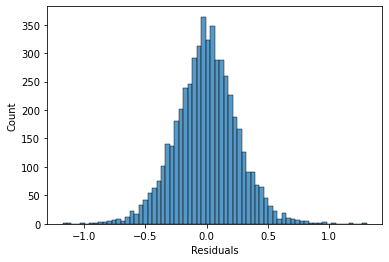

In [261]:
import scipy.stats as stats

residuals = (y_test - prediction)
sns.histplot(residuals)
plt.xlabel('Residuals');
# sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

It seems that the histogram of residuals follows the normal distribution so, we might accept that the residuals are normally distributed.


## Investigating Multicollinearity (Independence Assumption)


In order to check if the features are independent or not, we will check the `variance_inflation_factor` and see if the values of each coefficient is below 5 or not. If the values are below 5, we may accept that the features are independent.

In [262]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
X_train_constant_added = sm.add_constant(X_train)
X_test_constant_added = sm.add_constant(X_test)

vif = [
    variance_inflation_factor(X_train_constant_added.values, i) 
    for i in 
       range(X_train_constant_added.shape[1])
      ]
variance_inf_fact = pd.Series(vif, index=X_train_constant_added.columns,
                              name="Variance Inflation Factor")
variance_inf_fact

const                2.759625e+06
bedrooms             1.680581e+00
sqft_living          3.069384e+00
floors               1.495836e+00
yr_built             1.619488e+00
lat                  1.090620e+00
waterfront_impute    1.010457e+00
10 Very Good         2.374400e+00
11 Excellent         1.520302e+00
12 Luxury            1.058862e+00
4 Low                1.010572e+00
5 Fair               1.103537e+00
7 Average            3.757455e+00
8 Good               4.474132e+00
9 Better             3.622918e+00
Name: Variance Inflation Factor, dtype: float64

We can see that all the values are below 5 so we may conclude that the features are independent from one another and we do not have collinearity in our model.

## Investigating Homoscedasticity

We need to check if the residuals satisfy the "Homoscedasticity" assumptions. In order to check the if this is the case or not, we check the scatter plot of predicted values and the residuals.  

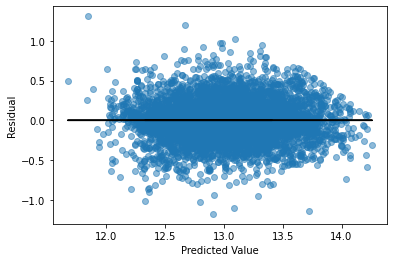

In [263]:
fig, ax = plt.subplots()

ax.scatter(prediction, residuals, alpha=0.5)
ax.plot(prediction, [0 for i in range(len(X_test))], color = "black")
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Residual");

It can be seen that the scatter plot of predicted values and the residuals is almost satisfying the homoscedasticity assumption expect some individual points. 

## Investigating Linearity

At the end, we should make sure that the predicted values and the actual values are linear. In order to do so, we draw a line and we check the scatter plot of actual values vs. predicted value as:

11.326595886778735 14.297936707208567
11.67919343736753 14.259572840391826


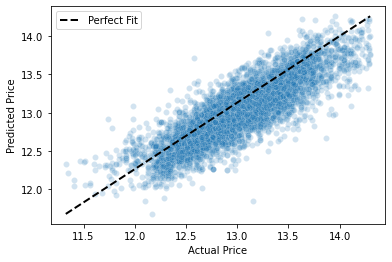

In [264]:
fig, ax = plt.subplots()

prediction = final_model.predict(X_test)


test_line = np.linspace(y_test.min(), y_test.max(), 200)
prediction_line = np.linspace(prediction.min(), prediction.max(), 200)
sns.lineplot(x = test_line, y = prediction_line
           , linestyle="--",
        color="black", label="Perfect Fit",
       lw = 2);
sns.scatterplot(x = y_test, y = prediction, alpha=0.2);
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();
print(y_test.min(), y_test.max())
print(prediction.min(), prediction.max())

It can be seen that the diagram is pretty linear and we can conclude that the linearity assumption is satisfied.

# Summary and Suggestions

Given that we cannot find a perfect model, each model has its own pros and cons. The model we proposed try to predict the price of a property in King County, WA by using `bedrooms`, `sqft_living`, `floors`, `yr_built`, `lat` as numerical features and `grade` of a house and its water front view as the categorical value. This model has a mean of the cross validation score of `{{np.round(secondmodel_scores["test_score"].mean(), 3)}}`. 

We realized that `lat` has the highest coefficient with respect to other numerical features which means that this feature might have the highest impact on the price of a property. Since the latitude and longitude of a property represent the coordinate of the property on the earth, these columns contain the information about the location and zip code of the property. Therefore, it makes sense that `lat` should have a highest coefficient among others since it represents to location of a property. After `lat` , `sqft_living` has the second highest impact on the price of a property. Moreover, we noticed that increasing the number of bedrooms may result in reducing the price of a property.

Among the categorical variables, we realize that improving the grade of a property to *Luxury* will increase the price of the property since this feature has the highest coefficient among other categorical variable.

Since one can not change the location of a property, it makes sense to increase the grade of the property. Therefore, we strongly suggest to improve the grade of a property because in turn the price of the house will increase greatly. 

In summary in order for King County to increase the value of a property, we would suggest the following ways:

**1. Increase the square footage of living area by reducing the number of bedrooms.**

**2. Increase the grade of the property at lease to very good.**

# Next Steps


It is important to mention that we would get different results by considering different features in the model. Therefore, we would suggests next steps to improve the predictions

**1. Adding other features such as `sqft_basement` and `yr_renovated` to the model.**

**2. Adding some combination of features into the model.**

**3. Considering adding polynomial features to the model.**
